In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - gaiadr2-apogee_velocity_maps.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''

'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
# import glob
# import subprocess

## Plotting
from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
# from matplotlib import cm
# import aplpy

## Astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs
from astropy.coordinates import CartesianDifferential

## galpy & astroNN
# from galpy import orbit
# from galpy import potential
# from galpy.util import bovy_coords as gpcoords
import astroNN.apogee

## Scipy
from scipy.stats import binned_statistic_2d

In [3]:
### Keywords
plt.rc('usetex:True')

# Load AstroNN catalogs and perform cuts

In [4]:
### Load catalogs

# Names
abundance_catalog = '../../data/astronn/astroNN_apogee_dr14_catalog.fits'
distance_catalog = '../../data/astronn/apogee_dr14_nn_dist_0562.fits'
apogee_catalog = astroNN.apogee.allstar(dr=14)

# Load and extract data
abund_file = fits.open(abundance_catalog)
abund_data = abund_file[1].data
dist_file = fits.open(distance_catalog)
dist_data = dist_file[1].data
ap_file = fits.open(apogee_catalog)
ap_data = ap_file[1].data

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/Users/JamesLane/Software/Python/External/data/apogee/sdss_local_sas_mirror/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!


In [5]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = abund_data['APOGEE_ID']
locid = abund_data['LOCATION_ID']
abunds = abund_data['astroNN']
abunds_err = abund_data['astroNN_error']
ra = abund_data['RA']
dec = abund_data['DEC']
logg, mg, si, ca, fe = abunds[:,[1,7,9,13,19]].T
slogg, smg, ssi, sca, sfe = abunds_err[:,[1,7,9,13,19]].T

# Distance, distance error, pmRA, pmDec
dist = dist_data['pc'] / 1000 # In kpc
sdist = dist_data['pc_error'] / 1000 # In kpc
fsdist = sdist / dist
pmra = dist_data['pmra']
pmdec = dist_data['pmdec']

# Radial velocity
vrad = ap_data['VHELIO_AVG']

# Make into a mega-array for easy cutting. Separate by floats and string
all_data_str = np.array([apid, locid]).T
all_data_flt = np.array([ra, dec, logg, mg, si, ca, fe, dist,
                         slogg, smg, ssi, sca, sfe, sdist, pmra, 
                         pmdec, vrad ]).T

In [6]:
### Perform cuts

# Find stars with logg error > 0.2 dex, 
# and fractional distance error > 0.2
good_stars = np.where(  ( slogg < 0.2 ) &
                        ( fsdist < 0.2 ) &
                        ( pmra != -9999 ) &
                        ( pmdec != -9999 ) &
                        ( ~np.isnan(pmra) ) &
                        ( ~np.isnan(pmdec) )
                     )[0]

# Cut the large arrays
all_data_flt = all_data_flt[good_stars]
all_data_str = all_data_str[good_stars]

# Unpack the data
apid, locid = all_data_str.T
ra, dec, logg, mg, si, ca, fe, dist, slogg, smg, ssi, sca, sfe, sdist, pmra, pmdec, vrad = all_data_flt.T

In [7]:
### Make metallicities w.r.t. Fe

mgfe = mg-fe
sife = si-fe
cafe = ca-fe

# Convert to galactocentric coordinates

In [8]:
### First define the LSR frame:

x_sun = 8.125 # Gravity team
z_sun = 0.0208 # Bennett & Bovy 2018
SgrA_pmra = 6.379 # Reid (2004)
u = 11.1  # }
v = 12.24 # } Schoenrich
w = 7.25  # }
v += (SgrA_pmra * x_sun * 4.74) # Gravity x Reid (2004) SgrA* PM

In [9]:
### Make SkyCoord

# Initiate with LSR kinematics from above.
coords = SkyCoord(ra = ra*apu.degree,
                  dec = dec*apu.degree,
                  distance = dist*apu.kpc,
                  pm_ra_cosdec = pmra*apu.mas/apu.yr,
                  pm_dec = pmdec*apu.mas/apu.yr,
                  radial_velocity = vrad*apu.km/apu.s,
                  galcen_distance = x_sun*apu.kpc,
                  z_sun = z_sun*apu.kpc,
                  galcen_v_sun = CartesianDifferential([u, v, w]*apu.km/apu.s))

In [10]:
### Transform into new frames

coords_gal = coords.transform_to('galactic')
coords_gc = coords.transform_to('galactocentric')

# Get galactic proper motions in mas/yr
pmll = coords_gal.pm_l_cosb.value
pmbb = coords_gal.pm_b.value

# Get galactocentric positions in kpc
gc_x = coords_gc.x.value * -1 # Flip for LH
gc_y = coords_gc.y.value
gc_z = coords_gc.z.value

# Make some plots showing the spatial distribution of values

In [11]:
### Function definitions

def hist_gcxy(x, y, vals, vmin, vmax, stat, low_N_mask, no_N_mask, cmap):
    
    # Make the histogram using the supplied value and stat. Stat must be 
    # compatible with binned_statistic_2d, either 'median' or np.std
    hist, xedges, yedges, binid = binned_statistic_2d(x, y, values=vals, statistic=stat,
                                                      bins=n_bins, range=hist_range)

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
    img_mask = ax.imshow(low_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    img_mask = ax.imshow(no_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Orange')
    orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

def B12_model(x_hi, x_lo, y_hi, y_lo, n_bins):
    
    ### Assumes x positive away from galactic center.
    
    # First make a grid of points
    gc_x_samp = np.linspace(x_lo, x_hi, n_bins)
    gc_y_samp = np.linspace(y_lo, y_hi, n_bins)
    gc_xv_samp, gc_yv_samp = np.meshgrid(gc_x_samp, gc_y_samp)

    # Now convert the points into galactic l and galactocentric phi
    gc_lv_samp = np.arctan2( gc_yv_samp, -1*(gc_xv_samp-x_sun) )
    gc_phiv_samp = np.arctan2( gc_yv_samp, gc_xv_samp )

    # Now calculate the velocity field
    gc_losv_samp = 218*( 1 - 0.0028*np.sqrt(np.square(gc_xv_samp)+np.square(gc_yv_samp)) )*np.sin( gc_phiv_samp + gc_lv_samp ) + (11)*np.cos( gc_lv_samp ) - (245)*np.sin(gc_lv_samp)

    # Now it will be ready for plotting once it is flipped:
    return gc_losv_samp[:,::-1]
#def

In [12]:
### Make a galactic z cut:

where_z_select = np.where(np.abs(gc_z) < 0.3)
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [13]:
### Prepare for plotting
n_bins = 25

x_hi = 15
x_lo = 0
y_hi = 10
y_lo = -5
hist_range = [ [x_lo,x_hi], [y_lo,y_hi] ]

plt.close('all')

# Plot density

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


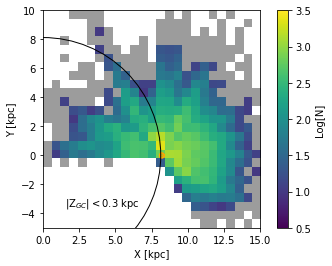

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

hist, xedges, yedges = np.histogram2d(gc_x[where_z_select], gc_y[where_z_select], bins=n_bins, range=hist_range)

# Rotate to account for histogram -> plotting grid
hist = np.rot90(hist)

# Find low-N bins. As long as histogram geometry remains the same this will be 
# used for greying out values.
where_low_N = np.where( (hist < 10) & (hist > 0) )
low_N_mask = np.zeros((n_bins,n_bins,4))
low_N_mask[:,:,3] = 0.0
low_N_mask[where_low_N[0],where_low_N[1],:3] = 100
low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

# Find 0-N bins. This will differentiate between no data and too little data
where_no_N = np.where( hist == 0 )
no_N_mask = np.zeros((n_bins,n_bins,4))
no_N_mask[:,:,3] = 0.0
no_N_mask[where_no_N[0],where_no_N[1],:3] = 1
no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0

img = ax.imshow(np.log10(hist), interpolation='nearest',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='viridis', vmin=0.5, vmax=3.5)
low_N_img = ax.imshow(low_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
no_N_img = ax.imshow(no_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

cbar = plt.colorbar(img)
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Orange')
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
cbar.set_label('Log[N]')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('N_hist.pdf')
plt.close(fig)

# Plot radial velocity

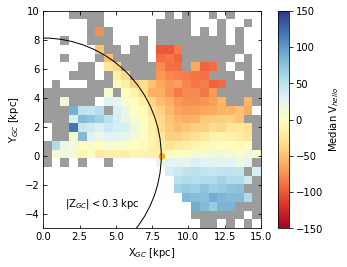

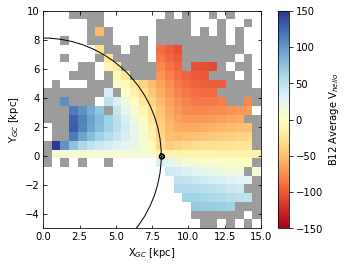

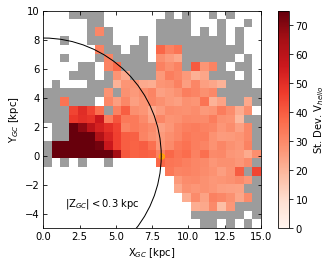

In [19]:
### Values
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], vrad[where_z_select],
                          -150, 150, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{helio}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('Vrad_hist.pdf')


### B12 Model
fig = plt.figure()
ax = fig.add_subplot(111)

# Make the grid
gc_losv_samp = B12_model(x_lo, x_hi, y_lo, y_hi, n_bins)

# Plot the image. Rotate to account for histogram => plotting grid
img = ax.imshow(gc_losv_samp, interpolation='nearest',
                extent=[x_lo, x_hi, y_lo, y_hi],
                cmap='RdYlBu', vmin=-150, vmax=150)

# Add the image masks. Assumes same geometry as hist.
img_mask = ax.imshow(low_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
img_mask = ax.imshow(no_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Colorbar
cbar = plt.colorbar(img)

# Add the sun and it's orbit
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black')
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

# Decorate
ax.set_xlabel(r'X$_{GC}$ [kpc]')
ax.set_ylabel(r'Y$_{GC}$ [kpc]')
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)
ax.tick_params(direction='in', top='on', right='on')
cbar.set_label(r'B12 Average V$_{helio}$')

plt.show()
fig.savefig('B12_model.pdf')


### Standard deviation
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], vrad[where_z_select],
                          0, 75, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. V$_{helio}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('Vrad_err_hist.pdf')
plt.close('all')

# Proper motion galactic longitude

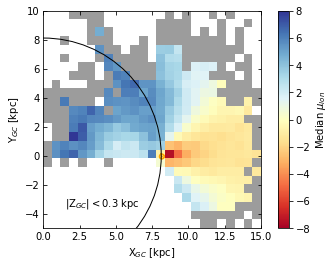

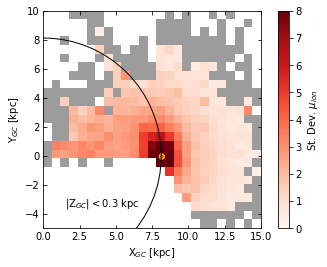

In [23]:
# Values
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], -1*pmll[where_z_select],
                          -8, 8, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median $\mu_{lon}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('pmll_hist.pdf')

# Standard deviation
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], pmll[where_z_select],
                          0, 8, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. $\mu_{lon}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('pmll_err_hist.pdf')
plt.close('all')

# Proper motion galactic latitude

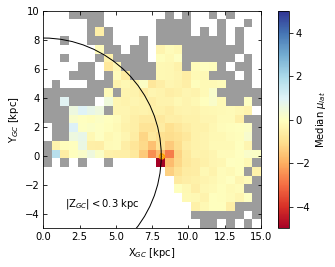

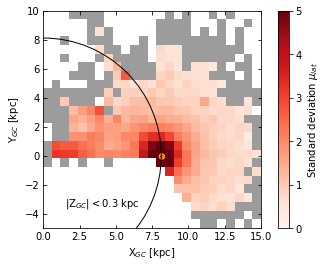

In [24]:
# Values.
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], pmbb[where_z_select],
                          -5, 5, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median $\mu_{lat}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('pmbb_hist.pdf')

# Standard deviation
fig = plt.figure()
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x[where_z_select], gc_y[where_z_select], pmbb[where_z_select],
                          0, 5, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'Standard deviation $\mu_{lat}$')
ax.annotate(z_select_text, xy=(0.1,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('pmbb_err_hist.pdf')
plt.close('all')

# Make plots of the B12 model

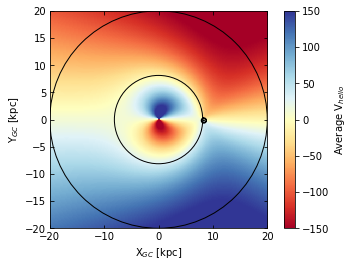

In [25]:
# First make a grid of points
gc_losv_samp = B12_model(-20,20,-20,20,400)

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the image. Rotate to account for histogram => plotting grid
img = ax.imshow(gc_losv_samp, interpolation='nearest',
                extent=[-20,20,-20,20],
                cmap='RdYlBu', vmin=-150, vmax=150)

# Colorbar
cbar = plt.colorbar(img)

# Add the sun and it's orbit
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black')
orbit_circle = plt.Circle((0,0), x_sun, edgecolor='Black', facecolor='None')
outter_circle = plt.Circle((0,0), 20, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)
ax.add_artist(outter_circle)

# Decorate
ax.set_xlabel(r'X$_{GC}$ [kpc]')
ax.set_ylabel(r'Y$_{GC}$ [kpc]')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.tick_params(direction='in', top='on', right='on')
cbar.set_label(r'Average V$_{helio}$')

plt.show()
fig.savefig('B12_model_full.pdf')
